In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F

import refsr
import numpy as np

import images as I
import utils as U

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import os
import os.path as path

from PIL import Image

In [2]:
matplotlib.rc("savefig", dpi=100)
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.getcwd()

'D:\\Josm\\Workspace\\ComputerVision\\GuidedTextureTransfer'

In [3]:
is_cuda=True
sr_model = refsr.get_default_sr_model(cuda=is_cuda)
vgg_model = refsr.get_default_vgg_model(cuda=is_cuda)
method = refsr.RefSR(sr_model, vgg_model)

In [4]:
def showimg(img, title=None):
    if isinstance(img, torch.Tensor):
        img = I.to_pil_image(img)[0][0]
        
    if title is not None:
        print(title)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

In [5]:
def load_data(imgpath, scale=1):
    dirname = path.dirname(imgpath)
    filename = path.basename(imgpath)
    basename, ext = path.splitext(filename)
    
    segpath = os.path.join(dirname, "prob", basename + "_seg.pth")
    
    img = I.load_image(imgpath, resize_scale=scale)
    
    segmap = torch.load(segpath)
    segmap = F.interpolate(segmap.unsqueeze(0), scale_factor=scale, mode="bicubic", align_corners=True).squeeze(0)
    
    assert img.dim() == 3
    assert segmap.dim() == 3
    assert img.shape[-2:] == segmap.shape[-2:]
    
    return img, segmap

def image_patches(h, w, s, img, *others):
    assert img.dim() == 3
    assert all([o.dim() == 3 for o in others])
    
    outputs = []
    
    patch = img[:, h:h+s, w:w+s]
    outputs.append(patch)
    
    _, ih, iw = img.size()
    for o in others:
        _, oh, ow = o.size()
        rh, rw = oh / ih, ow / iw
        patch = o[:, int(h*rh):int((h+s)*rh), int(w*rw):int((w+s)*rw)]
        outputs.append(patch)
        
    return tuple(outputs)


x_hr_orig


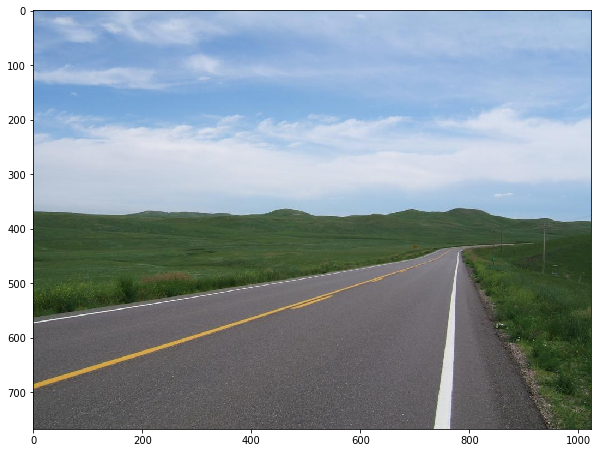

x_lr_orig


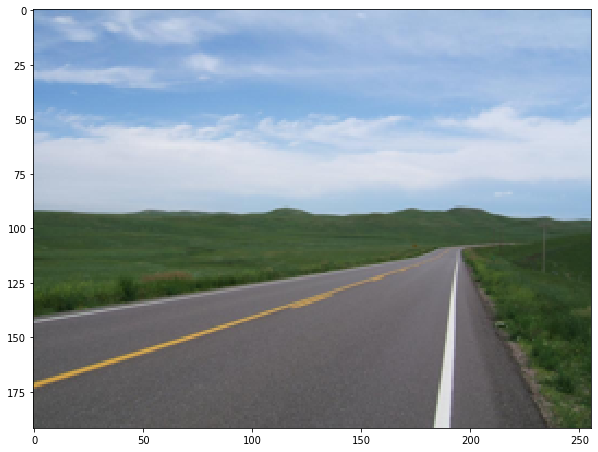

x_hr


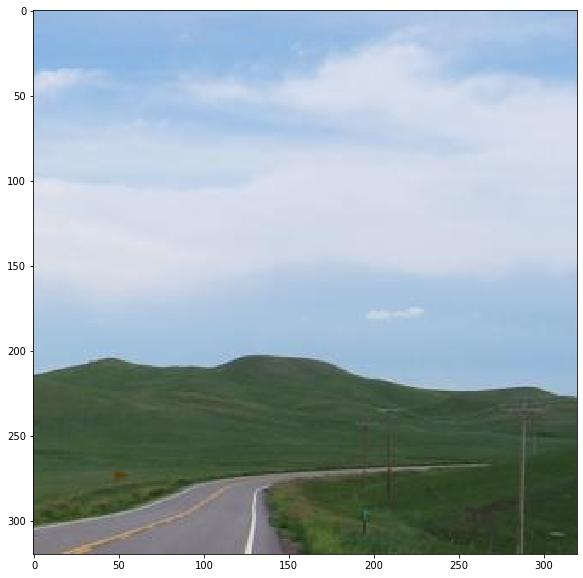

x_hr


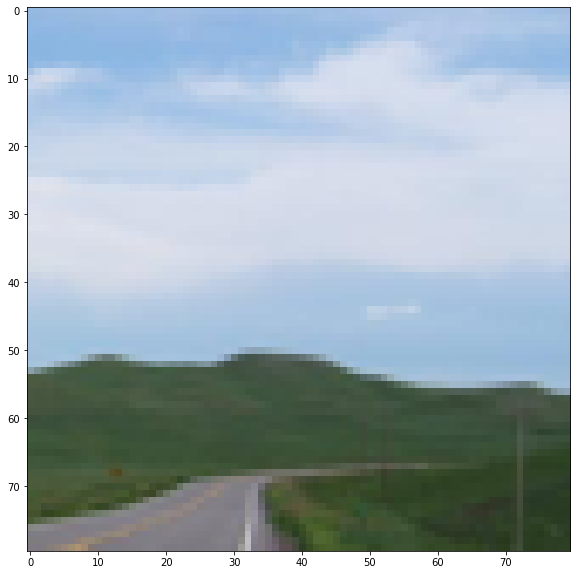

r1


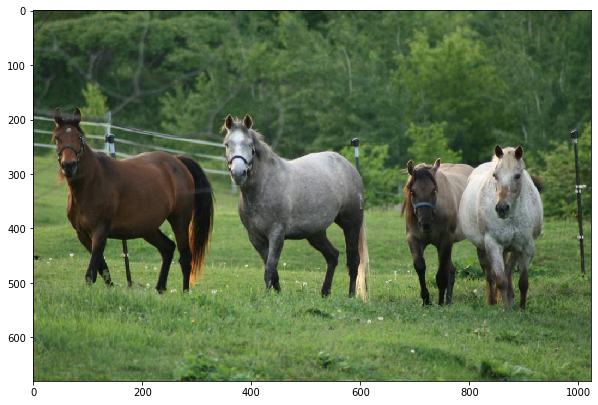

r2


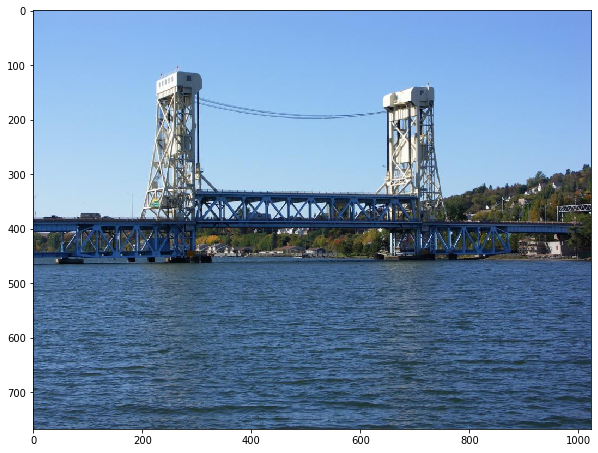

In [6]:
x_hr_orig, x_hr_seg_orig = load_data("samples/input.png")
x_lr_orig, x_lr_seg_orig = load_data("samples/input.png", scale=0.25)

x_hr, x_hr_seg, x_lr, x_lr_seg = image_patches(160, 650, 320, x_hr_orig, x_hr_seg_orig, x_lr_orig, x_lr_seg_orig)

r1, r1_seg = load_data("samples/r1.png")
r2, r2_seg = load_data("samples/r2.png")

showimg(x_hr_orig, "x_hr_orig")
showimg(x_lr_orig, "x_lr_orig")
showimg(x_hr, "x_hr")
showimg(x_lr, "x_hr")
showimg(r1, "r1")
showimg(r2, "r2")

In [7]:
target_hr = x_hr
input_lr = x_lr
input_lr_seg = x_lr_seg

In [8]:
def loss(a, b):
    return (a.cuda() - b.cuda()).abs().mean()

def run_ref_seg(t, x, xseg, r, rseg):
    with torch.no_grad():
        if is_cuda:
            y=method.upscale_with_ref_with_seg(
                x=x.cuda(),
                x_seg=xseg.cuda(),
                refs=U.cuda_all(*r),
                refs_seg=U.cuda_all(*rseg),
            )
            torch.cuda.empty_cache()
        else:
            y=method.upscale_with_ref_with_seg(
                x=x,
                x_seg=xseg,
                refs=U.cuda_all(*r),
                refs_seg=U.cuda_all(*rseg),
            )
    
    print("--------------------------")
    showimg(x, "Input")
    for i, rr in enumerate(r):
        showimg(rr, f"Referece {i}")
    showimg(y, "Output")
    showimg(t, "Target")
    print("Loss", loss(t, y))
    print("--------------------------")
    
    return y
def run_ref(t, x, r):
    with torch.no_grad():
        if is_cuda:
            y=method.upscale_with_ref(
                x=x.cuda(),
                refs=U.cuda_all(*r),
            )
            torch.cuda.empty_cache()
        else:
            y=method.upscale_with_ref(
                x=x,
                refs=U.cuda_all(*r),
            )
            
    print("--------------------------")
    showimg(x, "Input")
    for i, rr in enumerate(r):
        showimg(rr, f"Referece {i}")
    showimg(y, "Output")
    showimg(t, "Target")
    print("Loss", loss(t, y))
    print("--------------------------")
    return y

patches.size() torch.Size([42672, 256, 3, 3])

Doing classidx 00

Doing layer 1
CondH=80, CondW=80
RH=1, RW=1
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=78, Addr_W=78
Subset torch.Size([42672, 256, 3, 3])
PatchSize torch.Size([42672, 256, 3, 3])
NewPatch_H=3, NewPatch_W=3
outputs.size torch.Size([256, 80, 80])
counts.size torch.Size([80, 80])
last_i=77, last_i_start=77, last_i_end=80
last_j=77, last_j_start=77, last_j_end=80
mask.mean() tensor(0.0688, device='cuda:0')
mask.size() torch.Size([1, 1, 80, 80])

Doing layer 2
CondH=80, CondW=80
RH=2, RW=2
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=78, Addr_W=78
Subset torch.Size([42672, 128, 6, 6])
PatchSize torch.Size([42672, 128, 6, 6])
NewPatch_H=6, NewPatch_W=6
outputs.size torch.Size([128, 160, 160])
counts.size torch.Size([160, 160])
last_i=77, last_i_start=154, last_i_end=160
last_j=77, last_j_start=154, last_j_end=160
mask.mean() tensor(0.0673, device='cuda:0')
mask.size() torch.Size([1, 1, 160, 160])

Doing layer 3


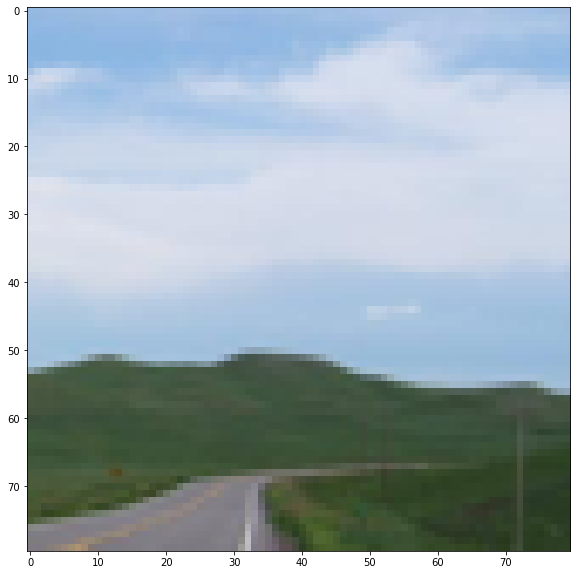

Referece 0


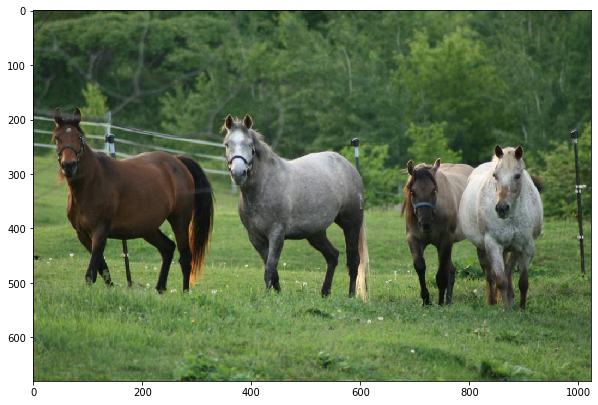

Output


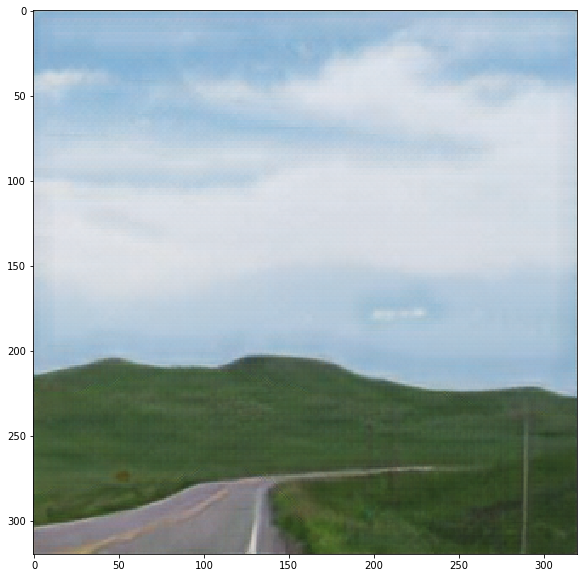

Target


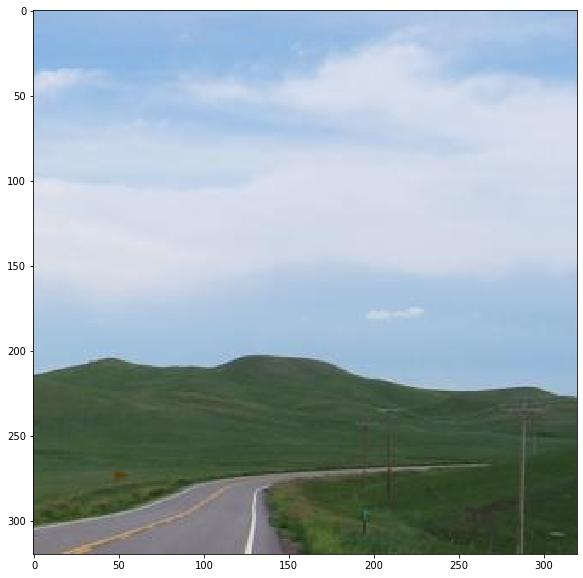

Loss tensor(5.6894, device='cuda:0')
--------------------------
Ok


In [9]:
run_ref_seg(target_hr, input_lr, input_lr_seg, [r1], [r1_seg])
print("Ok")

patches.size() torch.Size([48260, 256, 3, 3])

Doing classidx 00

Doing layer 1
CondH=80, CondW=80
RH=1, RW=1
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=78, Addr_W=78
Subset torch.Size([48260, 256, 3, 3])
PatchSize torch.Size([48260, 256, 3, 3])
NewPatch_H=3, NewPatch_W=3
outputs.size torch.Size([256, 80, 80])
counts.size torch.Size([80, 80])
last_i=77, last_i_start=77, last_i_end=80
last_j=77, last_j_start=77, last_j_end=80
mask.mean() tensor(0.0688, device='cuda:0')
mask.size() torch.Size([1, 1, 80, 80])

Doing layer 2
CondH=80, CondW=80
RH=2, RW=2
Patch_H=3, Patch_W=3
Stride_H=1, Stride_W=1
Addr_H=78, Addr_W=78
Subset torch.Size([48260, 128, 6, 6])
PatchSize torch.Size([48260, 128, 6, 6])
NewPatch_H=6, NewPatch_W=6
outputs.size torch.Size([128, 160, 160])
counts.size torch.Size([160, 160])
last_i=77, last_i_start=154, last_i_end=160
last_j=77, last_j_start=154, last_j_end=160
mask.mean() tensor(0.0673, device='cuda:0')
mask.size() torch.Size([1, 1, 160, 160])

Doing layer 3


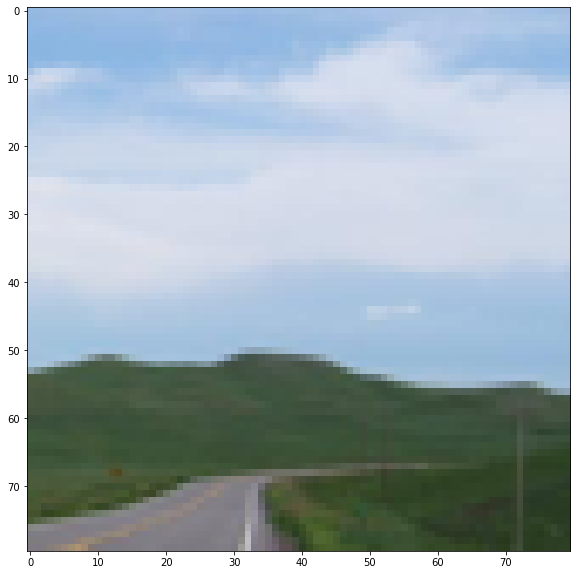

Referece 0


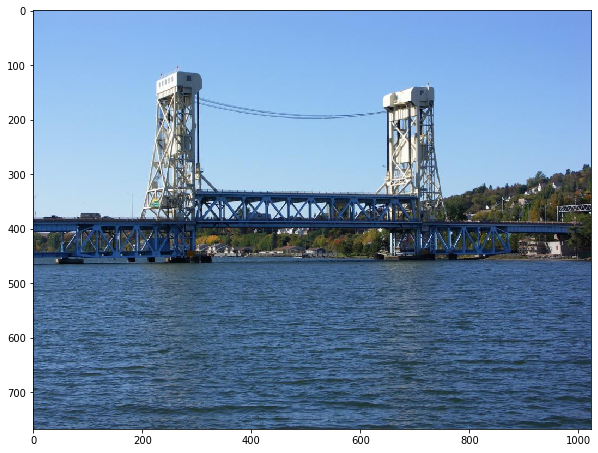

Output


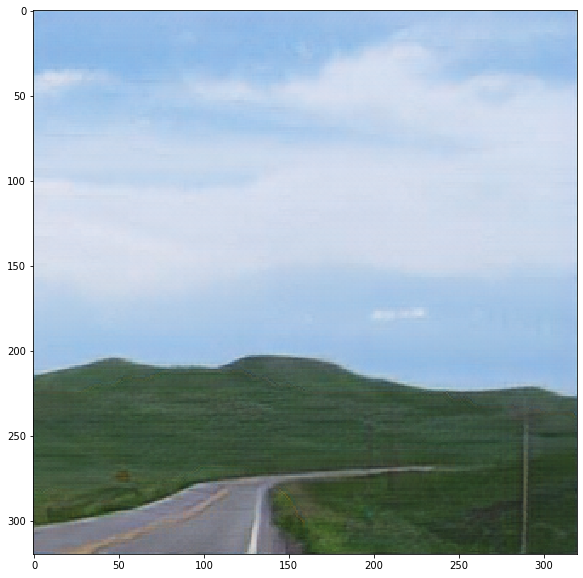

Target


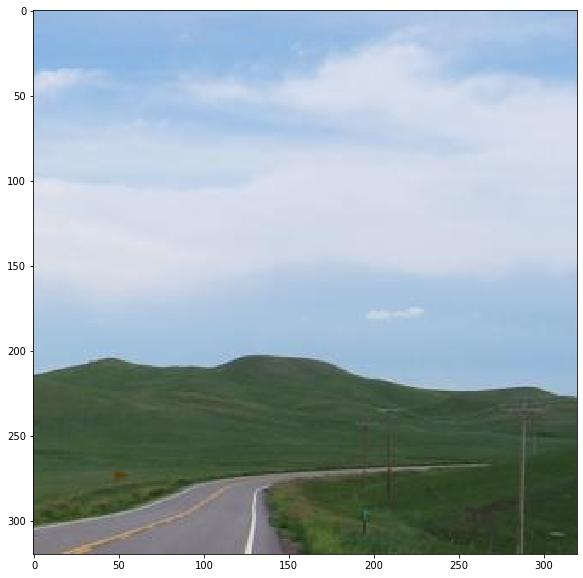

Loss tensor(4.2267, device='cuda:0')
--------------------------
Ok


In [10]:
run_ref_seg(target_hr, input_lr, input_lr_seg, [r2], [r2_seg])
print("Ok")

In [11]:
# run_ref_seg(target_hr, input_lr, input_lr_seg, [r1, r2], [r1_seg, r2_seg])
print("Ok")

Ok
